* Reference: 
__Empirical investigation of an equity pairs trading strategy__ _by_ Chen et al.<br>
$\;\;\;\;\;\;\;\;\;\;\;\;\;$ __Evaluation of pairs-trading strategy at the Brazilian financial market__ _by_ Perlin, M. S.<br>
$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$__Statistical arbitrage pairs trading strategies: Review and outlook__ _by_ Christopher Krauss


# Pearson Approach

This description of the distance approach closely follows the paper by _Chen et al._ __Empirical investigation of an equity pairs trading strategy__  [available here](http://www.pbcsf.tsinghua.edu.cn/research/chenzhuo/paper/Empirical%20Investigation%20of%20an%20Equity%20Pairs%20Trading%20Strategy.pdf). 

## Introduction

After the distance approach was introduced in the paper by Gatev et al. (2006), a lot of research has been
conducted to further develop the original distance approach. One of the adjustments is the Pearson correlation
approach proposed by Chen et al.(2012). In this paper, the authors use the same data set and time frame as
in the work by Gatev et al.(2006) but they used Pearson correlation on return level for forming pairs.
In the formation period(5 years in the paper), pairwise return correlations for all pairs in the universe
are calculated based on monthly return data. Then the authors construct a new variable, Return Divergence
($D_{i j t}$), to capture the return divergence between a single stock’s return and its pairs-portfolio returns:


$$D_{i j t}=\beta\left(R_{i t}-R_{f}\right)-\left(R_{j t}-R_{f}\right)$$


where $\beta$ denotes the regression coefficient of stock's monthly return $R_{i t}$ on its
pairs-portfolio return $R_{j t}$, and $R_{f}$ is the risk-free rate

The hypothesis in this approach is that if a stock’s return deviates from its pairs portfolio returns more
than usual, this divergence is expected to be reversed in the next month. And the returns of this stock are
expected to be abnormally high/low in comparison to other stocks.

Therefore, after calculating the return divergence of all the stocks,  a long-short portfolio is constructed
based on the long and short ratio given by the user.

## Pairs portfolio formation step


This stage of PearsonStrategy consists of the following steps:

1. **Data preprocessing**

As the method has to compute all of the pairs’ correlation values in the following steps, for $m$ stocks,
there are $\frac{m*(m-1)}{2}$ correlations to be computed in the formation period. As the number of
observations for the correlations grows exponentially with the number of stocks, this estimation is
computationally intensive.

Therefore, to reduce the computation burden, this method uses monthly stock returns data in the formation
period (ex. 60 monthly stock returns if the formation period is 5 years). If the daily price data is given,
the method calculates the monthly returns before moving into the next steps.

2. **Finding pairs**

For each stock, the method finds $n$ stocks with the highest correlations to the stock as its pairs using
monthly stock returns. After pairs are formed, returns of pairs, which refer to as pairs portfolios in the paper,
are needed to create $beta$ in the following step. Therefore, this method uses two different weighting
metrics in calculating the returns.


The first is an equal-weighted portfolio. The method by default computes the pairs portfolio returns as the
equal-weighted average returns of the top n pairs of stocks. The second is a correlation-weighted portfolio.
If this metric is chosen, the method uses the stock’s correlation values to each of the pairs and forms a
portfolio weighted by these values and the weights are calculated by the formula:



$$w_{k}=\frac{\rho_{k}}{\sum_{i=1}^{n} \rho_{i}}$$

where $w_{k}$ is the weight of stock k in the portfolio and $\rho_{i}$ is a correlation of the stock
and one of its pairs.

3. **Calculating beta**

After pairs portfolio returns are calculated, the method derives beta from the monthly return of the stock and
its pairs portfolio. By using linear regression, setting stock return as independent variable and pairs portfolio
return as the dependent variable, the methods set beta as a regression coefficient. Then the beta is stored in a
dictionary for future uses in trading. 

## Trading signals generation


After calculating the betas for all of the stocks in the formation period, the next step is to generate trading
signals by calculating the return divergence for each of the stocks. In this method, test data is not necessarily
required if only a trading signal for the last month of formation period is needed. However, if one wants to
see the backtesting results of the method and test with test data, a successive dataset after the formation period
is required to generate the proper trading signals. The steps are as follows:

1. **Data Preprocessing**

The same data preprocessing is done with the formation period as the data needs to be in the same format. As in
the formation period, risk free rate can be given in the form of either a float number of a series of data.

2. **Calculating the Return Divergence**

For every month of test data, starting from the very last month of the train data, return divergences are calculated
with the beta created in the formation period. The equation for calculating the return divergence is in the first section
of this documentation. Note that while the return divergence between a portfolio of $n$ most-highly correlated stocks
with stock i and stock $i$ is used as a sorting variable, only individual stock $i$ enters the portfolio
construction, not those $n$ stocks. The portfolio of those $n$ stocks only serves as a benchmark for portfolio sorting.

3. **Finding Trading Signals**

Then, all stocks are sorted in descending order based on their previous month's return divergence.  If the percentages
of long and short stocks are given, say $p\%$ and $q\%$, the top $p\%$ of the sorted stocks are chosen
for the long stocks and the bottom $q\%$ of the sorted stocks are chosen for the short stocks. If a user wants to
construct a dollar-neutral portfolio, one should choose the same percentage for $p$ and $q$. Finally,
a new dataframe is created with all of the trading signals: 1 if a stock is in a long position, -1 if it is in a short
position and 0 if it does not have any position.

## Results output 
The PearsonStrategy class contains multiple methods to get results in the desired form.

Functions that can be used to get data:

- **get_trading_signal()** outputs trading signal in monthly basis. 1 for a long position, -1 for a short position and 0 for closed position.

- **get_beta_dict()** outputs beta, a regression coefficients for each stock, in the formation period.

- **get_pairs_dict()** outputs top n pairs selected during the formation period for each of the stock.

## Usage of the Algorithms

Let's use the above strategy on real data. 

First, we will choose a training period of 12 months to form pairs. Second, we'll create trading signals for the following 6 months window. Finally, we will analyze the obtained results. 

In [1]:
import arbitragelab as al
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

### Loading data

As a dataset we'll download price time series for 272 stocks over a period from 01.2018 to 07.2019. First 5 years of data will be used for training and the following 1 year for trading signal generation and analysis of results. 

Here, we'll use tickers from S&P 500 which are in 4 main industry groups and will use Treasury Yield 10 Years (^TNX) rate as a risk free rate. However, any source of data can be applied the same as this.

In [2]:
# Get industry data from Wikipedia 
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
stock_table = table[0]

# Indutry groups to use are below
industry_group = ['Information Technology','Industrials','Financials',
                  'Health Care']

# Get tickers from S&P 500 which are in those industry groups
ticker_industry = stock_table[stock_table['GICS Sector']
                              .isin(industry_group)].reset_index(drop=True)

# Get a dataframe of ticker and industry group
ticker_industry = ticker_industry[['Symbol','GICS Sector']]

# Get tickers to use as a list
tickers = ticker_industry['Symbol'].to_list()
remove_tickers = ['CARR','ABC','BRK.B','VNT','OTIS'] # Removed tickers
tickers = [ticker for ticker in tickers if ticker not in remove_tickers]

# Get a dictionary of industry group
industry_dict = pd.Series(ticker_industry['GICS Sector'].values,
                        index=ticker_industry['Symbol']).to_dict()

# Loading data
train_data =  yf.download(tickers, start="2015-01-02", end="2018-12-31")
test_data =  yf.download(tickers, start="2019-01-02", end="2019-12-31")

# Taking close prices for chosen instruments
train_data = train_data["Adj Close"]
test_data = test_data["Adj Close"]

# Risk free rate for train and test
risk_free_train = yf.download("^TNX", start="2015-01-02", end="2018-12-31")
risk_free_test = yf.download("^TNX", start="2019-01-02", end="2019-12-31")

# Get a series of risk free rate from the data
risk_free_train = risk_free_train['Adj Close']/100
risk_free_test = risk_free_test['Adj Close']/100

# Looking at the downloaded data
train_data.head()

[*********************100%***********************]  272 of 272 completed
[*********************100%***********************]  272 of 272 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,A,AAL,AAPL,ABBV,ABMD,ABT,ACN,ADBE,ADI,ADP,...,WRB,WST,WU,XLNX,XRAY,XYL,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,38.282761,51.079918,24.861401,49.952694,37.310001,39.555874,79.256813,72.339996,48.195782,72.361244,...,29.963839,50.301605,14.316763,38.451271,49.762207,35.036499,107.075958,77.430000,25.124016,41.451859
2015-01-05,37.565441,51.051483,24.161013,49.012623,37.070000,39.564690,77.918610,71.980003,47.319328,72.309143,...,29.697638,49.607258,14.181022,37.745739,49.417248,32.855911,111.070251,76.339996,24.182638,41.203007
2015-01-06,36.980247,50.255585,24.163294,48.770031,36.130001,39.115395,77.356567,70.529999,46.208588,71.709663,...,29.620731,48.758606,14.157068,37.198963,48.803959,32.662708,110.128769,75.790001,23.259026,40.801033
2015-01-07,37.471062,50.227158,24.502111,50.741142,37.279999,39.432537,78.980240,71.110001,46.694542,72.335167,...,29.650303,49.549385,14.021324,37.216599,50.068855,32.920322,112.867699,77.720001,23.481054,41.643276
2015-01-08,38.594246,50.843037,25.443539,51.271839,38.959999,40.243046,80.184631,72.919998,47.518917,73.994576,...,30.283297,50.523411,14.300796,38.045589,51.305004,33.168743,114.066002,79.379997,23.809643,42.284531


The risk free rate series should look like below.

In [3]:
risk_free_train.head()

Date
2015-01-02    0.02123
2015-01-05    0.02039
2015-01-06    0.01963
2015-01-07    0.01954
2015-01-08    0.02016
Name: Adj Close, dtype: float64

### Forming pairs portfolios

Now let’s form pairs portfolios and calculate beta for trading signals generation later. 

In [4]:
# Initialising an object containing needed methods
strategy = al.distance_approach.PearsonStrategy()

# Forming pairs portfolio with training data
strategy.form_portfolio(train_data, risk_free_train)

Some other strategies can be applied by changing the number of pairs in the pairs portfolio or changing the weight metric. 

In [5]:
# Initialising an object containing needed methods
strategy_corr = al.distance_approach.PearsonStrategy()

# Forming pairs portfolio with training data
strategy_corr.form_portfolio(train_data, risk_free_train, num_pairs=30,
                            weight='correlation')

For example, if we look at a pair of stocks (‘A’ and ‘TMO’), we can see that the monthly return moves very similarly to each other in the plot. 

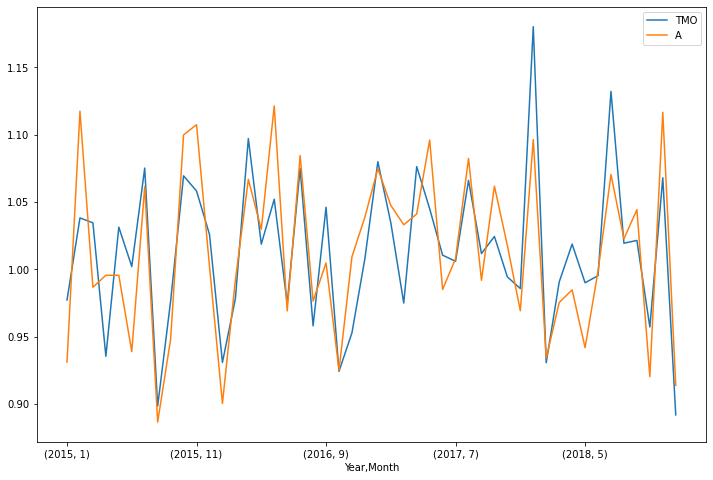

In [6]:
# Get a pair for the stock 'A'
A_pairs_5 = strategy_corr.pairs_dict['A'][:1]

# Appending the stock 'A' to the list 
A_pairs_5.append('A')

# Get monthly return data for both stocks
A_pairs_return = strategy_corr.monthly_return.loc[:,A_pairs_5]

# Plot the return graph
A_pairs_return.plot(figsize=(12,8));

Also, if we look at the beta, we can find a big difference in stocks with different beta values. Below is a figure showing two stocks with high beta(ENPH) and low beta(RE). We can clearly see that the stock with high beta has a bigger regression coefficient than the one with low beta.

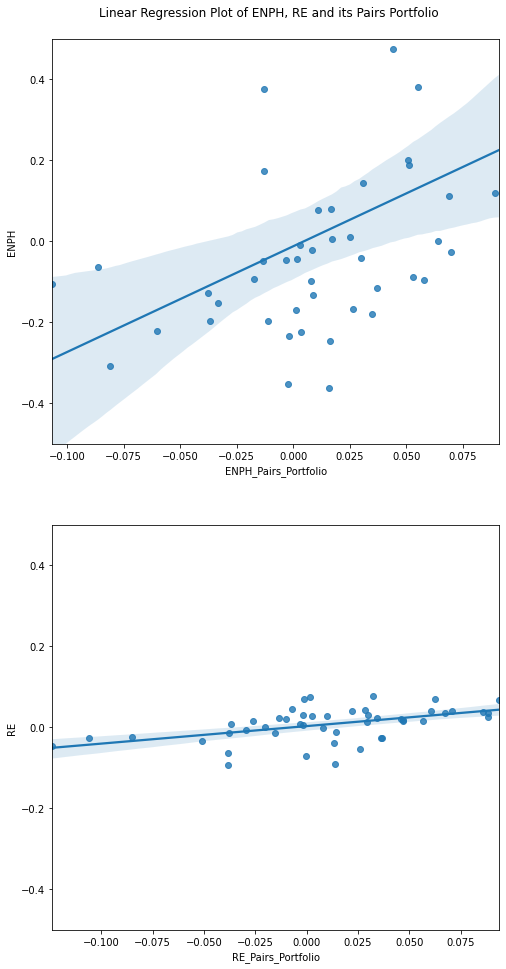

In [7]:
# Get beta and pairs for the strategy
beta,pairs = strategy.beta_dict, strategy.pairs_dict

# Sort the beta dictionary based on the value
beta_sorted = {k: v for k, v in sorted(beta.items(), 
                                       key=lambda item: item[1])}

# Get pairs and return of ENPH and RE
ENPH_pairs, RE_pairs = pairs['ENPH'], pairs['RE']
ENPH_return = strategy.monthly_return.loc[:,'ENPH']-1
RE_return = strategy.monthly_return.loc[:,'RE']-1

# Get pairs return of both stocks
ENPH_pairs_return = strategy.monthly_return.loc[:,ENPH_pairs] -1 
RE_pairs_return = strategy.monthly_return.loc[:,RE_pairs] -1 

# Get mean return for both of the stock pairs
ENPH_pairs_mean = ENPH_pairs_return.mean(axis=1)
RE_pairs_mean = RE_pairs_return.mean(axis=1)

# Create new dataframes to store both of the stock returns
ENPH = pd.concat([ENPH_return, ENPH_pairs_mean], axis=1)
RE = pd.concat([RE_return, RE_pairs_mean], axis=1)

# Reset the columns for clarification
ENPH.columns = ['ENPH','ENPH_Pairs_Portfolio']
RE.columns = ['RE', 'RE_Pairs_Portfolio']

# Set the fig settings
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(8,15))
fig.suptitle('Linear Regression Plot of ENPH, RE and its Pairs Portfolio')
fig.subplots_adjust(top=0.95)

# Plot two graphs
sns.regplot(ax=ax1, x="ENPH_Pairs_Portfolio", y="ENPH", data=ENPH)
ax1.set(ylim=(-0.5,0.5))

sns.regplot(ax=ax2, x="RE_Pairs_Portfolio",y="RE",data=RE);
ax2.set(ylim=(-0.5,0.5));

### Generating trading signals

Now let's generate trading signals for the testing dataset.

For correlation strategy, we'll adjust the long and short percentage of stocks in the final portfolio to see the differences.

In [8]:
# Gernerating trading signals for both of the strategies
strategy.trade_portfolio(test_data, risk_free_test)
strategy_corr.trade_portfolio(test_data, risk_free_test, long_pct=0.05, short_pct=0.05)

To check the trading signals for any of the strategy, we can just use the get_trading_signal method to call the dataframe as below.

In [9]:
# Get trading signal for strategy
strategy.get_trading_signal()

A  AAL  AAPL  ABBV  ABMD  ABT  ACN  ADBE  ADI  ADP  ...  WRB  \
Year Month                                                        ...        
2019 1      0.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  ... -1.0   
     2      0.0  0.0   0.0   1.0   0.0  0.0  0.0   0.0  0.0  0.0  ... -1.0   
     3      0.0  1.0   0.0   0.0   1.0  0.0  0.0   0.0  0.0  0.0  ... -1.0   
     4      0.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  ... -1.0   
     5      0.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  ... -1.0   
     6      0.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  ... -1.0   
     7      0.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  ... -1.0   
     8      0.0  1.0   0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  ... -1.0   
     9      0.0  1.0   0.0   0.0   1.0  0.0  0.0   0.0  0.0  0.0  ... -1.0   
     10     0.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  ... -1.0   
     11     0.0  0.0   0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  ... -1.0   
     12     0.0  1.0   0.0   0.0   1.0  0.0  0.0   0.0  0.0  0.0  ... -1.0   

            WST   WU  XLNX  XRAY  XYL  ZBH  ZBRA  ZION  ZTS  
Year Month                                                   
2019 1      0.0 -1.0   0.0   0.0  0.0  0.0   1.0   0.0  0.0  
     2      0.0  0.0  -1.0   0.0  0.0  0.0   1.0   0.0  0.0  
     3      0.0  0.0   0.0   0.0  0.0  0.0   1.0   0.0  0.0  
     4      0.0 -1.0   0.0   0.0  0.0  0.0   1.0   0.0  0.0  
     5      0.0  0.0   0.0   0.0  0.0  0.0   1.0   0.0  0.0  
     6      0.0 -1.0   0.0   0.0  0.0  0.0   1.0   0.0  0.0  
     7      0.0  0.0   0.0   0.0  0.0  0.0   1.0   0.0  0.0  
     8      0.0 -1.0   0.0   0.0  0.0  0.0   1.0   0.0  0.0  
     9      0.0 -1.0   0.0   0.0  0.0  0.0   1.0   0.0 -1.0  
     10     0.0 -1.0   0.0   0.0  0.0  0.0   1.0   0.0  0.0  
     11     0.0 -1.0   0.0   0.0  0.0  0.0   1.0   0.0  0.0  
     12     0.0 -1.0   0.0   0.0  0.0  0.0   1.0   0.0  0.0  

[12 rows x 272 columns]

Now let’s see some examples of equity curves generated by PearsonStrategy. 

In [85]:
def calc_cum_return(strategy):
    """
    Calculates cumulative return of each strategy in testing period.
    
    :param strategy: (PearsonStrategy) A strategy using PearsonStrategy
    :return: (pd.Series) 
    """
    
    # Get trading signals and monthly return on test period
    trading_signal = strategy.get_trading_signal()
    test_monthly_return = strategy.test_monthly_return
    # Mulitply the both dataframe to get a dataframe of returns with trading signal
    test_traded_return = test_monthly_return*trading_signal

    # To track the number of stocks traded and the sum of return for each month
    count = 0 # Number of stocks traded
    return_sum = 0 # Sum of the monthly return
    return_mean_list = [] # Monthly average return list
    
    # Loop through every month to calculate the mean return 
    for month in test_traded_return.index:
        
        month_series = test_traded_return.loc[month]
        
        # Loop through every stock in the month
        for stock_return in month_series:
            
            # If stock is in a short position, add 2 to the stock return so that we can 
            # calculate the actual return from the position for example, if it's -1.03, 
            # it becomes 0.97, which means in this short position, we have lost 3% for this stock. 
            if stock_return < 0:
                return_sum += 2+stock_return
                count+=1
            
            # If stock is in a long position, just add the return to the return sum
            elif stock_return >0:
                return_sum += stock_return
                count+=1
        
        # Add mean return for every stock in the month
        return_mean_list.append(return_sum/count)
    
    return_series = pd.Series(return_mean_list, index=test_traded_return.index)
    return_series = return_series.rename('Monthly Average Return')
    
    return return_series


For basic strategy, we have a monthly return series as below and the equity curve is given as well. 

In [88]:
calc_cum_return(strategy)

Year  Month
2019  1        1.041482
      2        1.027169
      3        1.015362
      4        1.015648
      5        1.005002
      6        1.012125
      7        1.010863
      8        1.005623
      9        1.005001
      10       1.006619
      11       1.009165
      12       1.009515
Name: Monthly Average Return, dtype: float64

Investment portfolio value rose to  1.1756908168917966


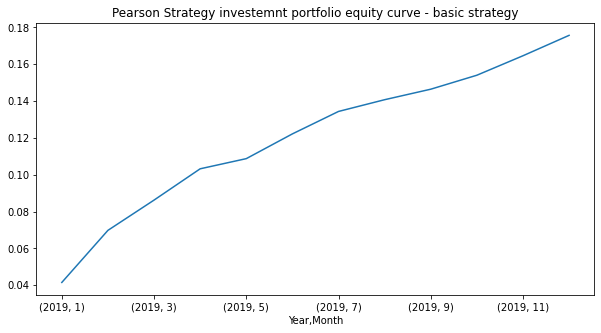

In [102]:
basic_strategy = calc_cum_return(strategy).cumprod()
basic_strategy_plot = basic_strategy-1
basic_strategy_plot.plot(title='Pearson Strategy investemnt portfolio equity curve - basic strategy', figsize=(10,5));
print('Investment portfolio value rose to ',basic_strategy.iloc[-1])

For correlation strategy, we have a monthly return series as below and the equity curve is given as well. 

In [89]:
calc_cum_return(strategy_corr)

Year  Month
2019  1        1.041857
      2        1.028963
      3        1.020410
      4        1.016381
      5        1.005902
      6        1.013942
      7        1.010930
      8        1.008057
      9        1.005277
      10       1.007449
      11       1.011172
      12       1.011436
Name: Monthly Average Return, dtype: float64

Investment portfolio value rose to  1.1969789617782034


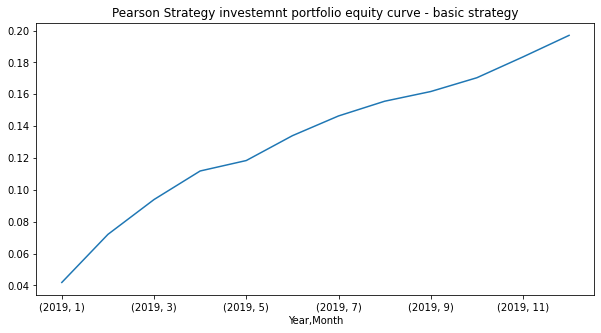

In [103]:
corr_strategy = calc_cum_return(strategy_corr).cumprod()
corr_strategy_plot = corr_strategy-1
corr_strategy_plot.plot(title='Pearson Strategy investemnt portfolio equity curve - basic strategy', figsize=(10,5));
print('Investment portfolio value rose to ',corr_strategy.iloc[-1])

## Conclusion

This notebook describes the Pearson Strategy class and its functionality. Also, it shows how the stages of the method (pairs portfolio formation and trading signals generation) can be used on real data and that this method can output profitable trading signals.

The algorithms and the descriptions used in this notebook were described the paper by _Chen et al._ __Empirical investigation of an equity pairs trading strategy__  [available here](http://www.pbcsf.tsinghua.edu.cn/research/chenzhuo/paper/Empirical%20Investigation%20of%20an%20Equity%20Pairs%20Trading%20Strategy.pdf). 


Key takeaways from the notebook:

- The Pearson distance approach has two work stages - pairs portfolio formation and trading signals generation.

- The Pearson approach works as follows:
    - First, after data is preprocessed, the method finds pairs for every stock based on the Pearson correlation. 
    - Then, by using linear regression, setting stock return as independent variable and pairs portfolio return as the dependent variable, the methods set beta as a regression coefficient.
    - After the pairs portfolio formation period, trading signals can be generated with test data.
    - The method selects long and short stocks for each month in the testing period by calculating the return divergence for each stock.
    - Then the trading signals are generated. 
    
- There can be two different ways of forming pairs portfolios.
    - By default, the method calculates equally weighted portfolios.
    - However, it can also calculates the portfolio return weighted by its pairs correlation coefficients.